# Create ACS Index and Azure SQL Database for Avatar Demo
Use this notebook to create an Azure Cognitive Search Index and an Azure SQL Database and populate demo content for the Avatar outdoor shop application.  

Ensure that you have the the Microsoft ODBC driver for SQL Server installed. Here are the instructions for Linux based systems:  
https://learn.microsoft.com/en-us/sql/connect/odbc/linux-mac/installing-the-microsoft-odbc-driver-for-sql-server?view=sql-server-ver16&tabs=ubuntu18-install%2Calpine17-install%2Cdebian8-install%2Credhat7-13-install%2Crhel7-offline#18


## Setup

In [1]:
# Install the required libraries
%pip install azure-search-documents==11.4.0b6 openai==0.28.1 tenacity pyodbc

In [2]:
import os
import json  
import pandas as pd

import pyodbc
import requests
import inspect

import openai  
from tenacity import retry, wait_random_exponential, stop_after_attempt  
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import Vector  
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,  
    SearchIndex,  
    SemanticConfiguration,  
    PrioritizedFields,  
    SemanticField,  
    SearchField,  
    SemanticSettings,  
    VectorSearch,  
    VectorSearchAlgorithmConfiguration,  
)  

You need to have the following settings for your Azure resources defined in the `local.settings.json` file in the __api__ subfolder to populate the demo content for the outdoor app:

In [3]:
# Load JSON file
with open('./api/local.settings.json', 'r') as file:
    data = json.load(file)

# Azure Cognitive Search
service_endpoint = data["Values"]["AZURE_SEARCH_ENDPOINT"]
key = data["Values"]["AZURE_SEARCH_API_KEY"]
index_name = data["Values"]["AZURE_SEARCH_INDEX"]

# Blob SAS URL for Azure Storage Account
blob_sas_url = data["Values"]["BLOB_SAS_URL"]

# Azure OpenAI
openai.api_type = "azure"
openai.api_key = data["Values"]["AZURE_OPENAI_API_KEY"]
openai.api_base = data["Values"]["AZURE_OPENAI_ENDPOINT"]
openai.api_version = data["Values"]["AZURE_OPENAI_API_VERSION"]
AOAI_embeddings_deployment = data["Values"]["AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT"]

# Azure SQL Database
sql_db_server = data["Values"]["SQL_DB_SERVER"]
sql_db_user = data["Values"]["SQL_DB_USER"]
sql_db_password = data["Values"]["SQL_DB_PASSWORD"]
sql_db_name = data["Values"]["SQL_DB_NAME"]

## Create Cognitive Search Index
First, we create a new Index with demo data to the Cognitive Search service that you have deployed manually.

In [4]:
credential = AzureKeyCredential(key)

df = pd.read_csv('data/products_cs_index.csv', dtype={'id': str})
display(df.head())
input_data = df.to_dict(orient='records')

,id,category,name,tagline,description,original_price,special_offer,product_image_file
0,1000,outdoor,Elysian Voyager,The Ultimate 2-Person Travel Tent for the Mode...,"Meet the Elysian Voyager, the pinnacle of outd...",850.0,800.00,elysian-voyager.png
1,1001,outdoor,Terra Roamer,The All-in-One Travel Backpack for Uncharted J...,"Introducing the Terra Roamer, the embodiment o...",220.0,200.00,terra-roamer.png
2,1002,outdoor,Cardinal Pathfinder,The Ultimate Travel Compass for Modern Explorers,"Discover the Cardinal Pathfinder, a revolution...",55.0,49.99,cardinal-pathfinder.png
3,1003,outdoor,Slumber Drifter,The Ultimate Lightweight Travel Sleeping Bag f...,"Introducing the Slumber Drifter, a game-change...",90.0,80.00,slumber-drifter.png
4,1004,outdoor,Blaze Adventurer,The Future of Outdoor Cooking - The Portable T...,"Presenting the Blaze Adventurer, a cutting-edg...",75.0,67.99,blaze-adventurer.png


In [5]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
# Function to generate embeddings for title and content fields, also used for query embeddings
def generate_embeddings(text):
    response = openai.Embedding.create(
        input=text, engine=AOAI_embeddings_deployment)
    embeddings = response['data'][0]['embedding']
    return embeddings

In [6]:
# Generate embeddings for title and content fields
for item in input_data:
    tagline = item['tagline']
    description = item['description']
    tagline_embeddings = generate_embeddings(tagline)
    description_embeddings = generate_embeddings(description)
    item['tagline_vector'] = tagline_embeddings
    item['description_vector'] = description_embeddings

In [7]:
# Output embeddings to docVectors.json file
with open("./data/product-catalog-vectors.json", "w") as f:
    json.dump(input_data, f)

In [8]:
# Delete ACS index if it exists
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

try:
    if index_client.get_index(index_name):
        print('Deleting existing index...')
        index_client.delete_index(index_name)

except:
    print('Index does not exist. No need to delete it.')

Deleting existing index...


In [9]:
# Create a search index
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="name", type=SearchFieldDataType.String),
    SearchableField(name="tagline", type=SearchFieldDataType.String),
    SearchableField(name="description", type=SearchFieldDataType.String),
    SimpleField(name="original_price", type=SearchFieldDataType.Double),
    SimpleField(name="special_offer", type=SearchFieldDataType.Double),
    SearchableField(name="category", type=SearchFieldDataType.String, filterable=True),
    SearchField(name="tagline_vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, vector_search_dimensions=1536, vector_search_configuration="my-vector-config"),
    SearchField(name="description_vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, vector_search_dimensions=1536, vector_search_configuration="my-vector-config"),
    SimpleField(name="product_image_file", type=SearchFieldDataType.String),
]

vector_search = VectorSearch(
    algorithm_configurations=[
        VectorSearchAlgorithmConfiguration(
            name="my-vector-config",
            kind="hnsw",
            hnsw_parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 500,
                "metric": "cosine"
            }
        )
    ]
)

semantic_config = SemanticConfiguration(
    name="my-semantic-config",
    prioritized_fields=PrioritizedFields(
        title_field=SemanticField(field_name="tagline"),
        prioritized_keywords_fields=[SemanticField(field_name="category")],
        prioritized_content_fields=[SemanticField(field_name="description")]
    )
)

# Create the semantic settings with the configuration
semantic_settings = SemanticSettings(configurations=[semantic_config])

# Create the search index with the semantic settings
index = SearchIndex(name=index_name, fields=fields,
                    vector_search=vector_search, semantic_settings=semantic_settings)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')

 products created


In [10]:
# Upload documents to the index
with open("./data/product-catalog-vectors.json", 'r') as file:  
    documents = json.load(file)  
search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)
result = search_client.upload_documents(documents)  
print(f"Uploaded {len(documents)} documents") 

Uploaded 19 documents


## Perform Test Queries
We are performing a few test queries against the Cognitive Search index. If successful, it should display outdoor product information and images.

In [11]:
search_client = SearchClient(service_endpoint, index_name, credential=credential)  
fields_of_interest = ["id", "name", "tagline", "description", "original_price", "special_offer", "category", "product_image_file"]

Score: 0.83487445
Name: Elysian Voyager
Category: outdoor
Tagline: The Ultimate 2-Person Travel Tent for the Modern Adventurer
Description: Meet the Elysian Voyager, the pinnacle of outdoor 
Original price: 850.0
Special offer: 800.0
Image file: elysian-voyager.png



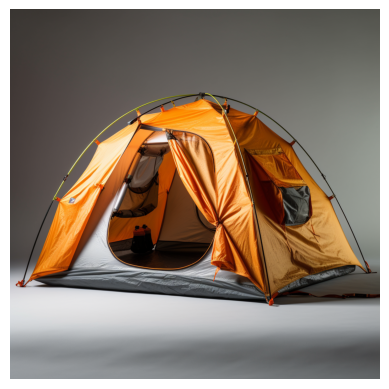

Score: 0.81059885
Name: Slumber Drifter
Category: outdoor
Tagline: The Ultimate Lightweight Travel Sleeping Bag for Every Adventure
Description: Introducing the Slumber Drifter, a game-changer in
Original price: 90.0
Special offer: 80.0
Image file: slumber-drifter.png



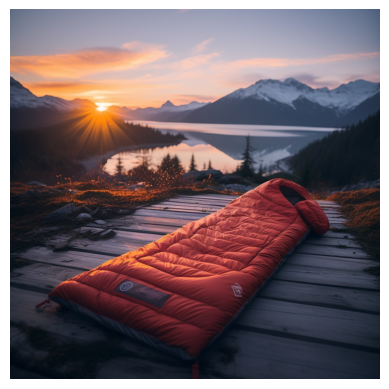

Score: 0.80658996
Name: Terra Roamer
Category: outdoor
Tagline: The All-in-One Travel Backpack for Uncharted Journeys
Description: Introducing the Terra Roamer, the embodiment of fr
Original price: 220.0
Special offer: 200.0
Image file: terra-roamer.png



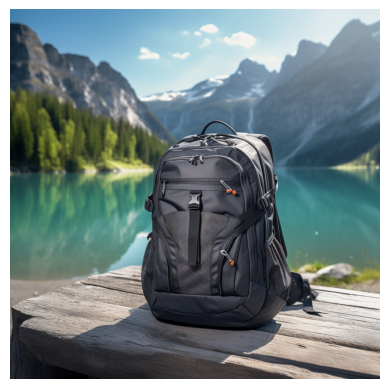

In [12]:
import requests
from matplotlib import pyplot as plt
from io import BytesIO

def display_image_from_blob(image_file):
   
  # Append the image name to the SAS URL
  image_url = blob_sas_url.split("?")[0] + f"/{image_file}?" + blob_sas_url.split("?")[1]

  # Get the image content
  response = requests.get(image_url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open the image and display it
      img = plt.imread(BytesIO(response.content))
      plt.imshow(img)
      plt.axis('off') # No axes for this plot
      plt.show()
  else:
      print(f"Failed to retrieve image. HTTP Status code: {response.status_code}")

def print_results(results):  
  for result in results:  
    print(f"Score: {result['@search.score']}")
    print(f"Name: {result['name']}")  
    print(f"Category: {result['category']}")
    print(f"Tagline: {result['tagline']}")
    print(f"Description: {result['description'][:50]}")
    print(f"Original price: {result['original_price']}")
    print(f"Special offer: {result['special_offer']}")
    print(f"Image file: {result['product_image_file']}\n")
    display_image_from_blob(result['product_image_file'])


# Pure Vector Search with Filter
query = "tent for two people"  
 
results = search_client.search(  
    search_text=None,  
    vector=generate_embeddings(query), top_k=3,  
    vector_fields="description_vector",
    filter="category eq 'outdoor'",
    select= fields_of_interest
)  
  
print_results(results)

## Create Azure SQL Database
Now we are creating a small Azure SQL Database with customer, products and order data using the SQL Server that you have deployed manually.

In [13]:
# Connection Strings
server_connection_string = f"Driver={{ODBC Driver 18 for SQL Server}};Server=tcp:{sql_db_server},1433;Uid={sql_db_user};Pwd={sql_db_password};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;"
database_connection_string = server_connection_string + f"Database={sql_db_name};"

In [14]:
import random

customers = [
    {"name": "John Doe", "account_id": 1000, "loyalty_points" : random.randint(400, 800)},
    {"name": "Jane Smith", "account_id": 1001, "loyalty_points" : random.randint(400, 800)},
    {"name": "Alice Johnson", "account_id": 1002, "loyalty_points" : random.randint(400, 800)},
    {"name": "Bob Wilson", "account_id": 1003, "loyalty_points" : random.randint(400, 800)},
    {"name": "Charlie Brown", "account_id": 1004, "loyalty_points" : random.randint(400, 800)},
    {"name": "Eve Adams", "account_id": 1005, "loyalty_points" : random.randint(400, 800)},
    {"name": "Frank Castle", "account_id": 1006, "loyalty_points" : random.randint(400, 800)},
    {"name": "Grace Lee", "account_id": 1007, "loyalty_points" : random.randint(400, 800)},
    {"name": "Hannah Montan", "account_id": 1008, "loyalty_points" : random.randint(400, 800)},
    {"name": "Ian Somerhalder", "account_id": 1009, "loyalty_points" : random.randint(400, 800)},
    {"name": "Peter Mick", "account_id": 1010, "loyalty_points" : random.randint(400, 800)},
]

products = [
    {"id": 1000, "name": "Elysian Voyager", "stock": random.randint(0,50)},
    {"id": 1001, "name": "Terra Roamer", "stock": random.randint(0,50)},
    {"id": 1002, "name": "Cardinal Pathfinder", "stock": random.randint(0,50)},
    {"id": 1003, "name": "Slumber Drifter", "stock": random.randint(0,50)},
    {"id": 1004, "name": "Blaze Adventurer", "stock": random.randint(0,50)},
    {"id": 1005, "name": "BiteShield Pro", "stock": random.randint(0,50)},
    {"id": 1006, "name": "Feast Frontier", "stock": random.randint(0,50)},
    {"id": 1007, "name": "Summit Stride", "stock": random.randint(0,50)},
    {"id": 1008, "name": "Rugged Ranger","stock": random.randint(0,50)},
    {"id": 1100, "name": "Match Master", "stock": random.randint(0,50)},
    {"id": 1101, "name": "Court Queen", "stock": random.randint(0,50)},
    {"id": 1102, "name": "Junior Ace", "stock": random.randint(0,50)},
    {"id": 1103, "name": "ServeMaster Pro", "stock": random.randint(0,50)},
    {"id": 1104, "name": "Court Commander", "stock": random.randint(0,50)},
    {"id": 1105, "name": "StringMaster Elite", "stock": random.randint(0,50)},
    {"id": 1106, "name": "Court Conqueror", "stock": random.randint(0,50)},
    {"id": 1107, "name": "AceMaster 3000", "stock": random.randint(0,50)},
    {"id": 1108, "name": "Ace Attire", "stock": random.randint(0,50)},
    {"id": 1109, "name": "Serve & Style", "stock": random.randint(0,50)},
]
orders = [
    {"order_id": 1000, "product_id": 1001, "days_to_delivery": random.randint(3,15), "account_id": 1000},
    {"order_id": 1001, "product_id": 1001, "days_to_delivery": random.randint(3,15), "account_id": 1001},
    {"order_id": 1002, "product_id": 1002, "days_to_delivery": random.randint(3,15), "account_id": 1002},
    {"order_id": 1003, "product_id": 1003, "days_to_delivery": random.randint(3,15), "account_id": 1003},
    {"order_id": 1004, "product_id": 1004, "days_to_delivery": random.randint(3,15), "account_id": 1004},
    {"order_id": 1005, "product_id": 1005, "days_to_delivery": random.randint(3,15), "account_id": 1005},
    {"order_id": 1006, "product_id": 1006, "days_to_delivery": random.randint(3,15), "account_id": 1006},
    {"order_id": 1007, "product_id": 1007, "days_to_delivery": random.randint(3,15), "account_id": 1007},
    {"order_id": 1008, "product_id": 1008, "days_to_delivery": random.randint(3,15), "account_id": 1008},
    {"order_id": 1010, "product_id": 1000, "days_to_delivery": random.randint(3,15), "account_id": 1009},
    {"order_id": 1012, "product_id": 1101, "days_to_delivery": random.randint(3,15), "account_id": 1001},
    {"order_id": 1013, "product_id": 1102, "days_to_delivery": random.randint(3,15), "account_id": 1002},
    {"order_id": 1014, "product_id": 1103, "days_to_delivery": random.randint(3,15), "account_id": 1003},
    {"order_id": 1015, "product_id": 1104, "days_to_delivery": random.randint(3,15), "account_id": 1004},
    {"order_id": 1016, "product_id": 1105, "days_to_delivery": random.randint(3,15), "account_id": 1005},
    {"order_id": 1017, "product_id": 1106, "days_to_delivery": random.randint(3,15), "account_id": 1006},
    {"order_id": 1018, "product_id": 1107, "days_to_delivery": random.randint(3,15), "account_id": 1007},
    {"order_id": 1019, "product_id": 1108, "days_to_delivery": random.randint(3,15), "account_id": 1008},
]

In [15]:
# Test connection to the SQL Server

try:
    # Try to establish a connection
    conn = pyodbc.connect(server_connection_string)
    
    # If connection is successful, print a message and close the connection
    print("Connection to the server/database was successful!")
    conn.close()
    
except pyodbc.Error as ex:
    # Catch any connection errors and print them
    sqlstate = ex.args[0] if len(ex.args) > 0 else None
    message = ex.args[1] if len(ex.args) > 1 else None
    print(f"Failed to connect to the server/database. SQLSTATE: {sqlstate}, Message: {message}")

Connection to the server/database was successful!


In [16]:
# SET TO TRUE ONLY TO REBUILD DATABASE BASED ON ABOVE SAMPLE DATA
rebuild_database = True

if rebuild_database:

    # Connect to the server without specifying a database
    server_conn = pyodbc.connect(server_connection_string, autocommit=True)
    server_cursor = server_conn.cursor()

    # Drop the database if it exists
    server_cursor.execute(f"IF EXISTS(SELECT * FROM sys.databases WHERE name='{sql_db_name}') DROP DATABASE {sql_db_name}")

    # Recreate the database
    server_cursor.execute(f"CREATE DATABASE {sql_db_name}")
    server_cursor.close()
    server_conn.close()

    # Now, connect to the newly created database
    conn = pyodbc.connect(database_connection_string)
    cursor = conn.cursor()

    # Ensure you're using the existing database
    cursor.execute(f"USE {sql_db_name}")

    # Create tables and populate them
    cursor.execute("""
    CREATE TABLE Customers (
        name VARCHAR(255),
        account_id INT PRIMARY KEY,
        loyalty_points INT,
    )
    """)

    for customer in customers:
        cursor.execute("INSERT INTO Customers VALUES (?, ?, ?)", 
                    (customer["name"], customer["account_id"], customer["loyalty_points"]))

    cursor.execute("""
    CREATE TABLE Products (
        id INT PRIMARY KEY,
        name VARCHAR(255),
        stock INT
    )
    """)

    for product in products:
        cursor.execute("INSERT INTO Products VALUES (?, ?, ?)", 
                    (product["id"], product["name"], product["stock"]))

    cursor.execute("""
    CREATE TABLE Orders (
        order_id INT PRIMARY KEY,
        product_id INT,
        days_to_delivery INT,
        account_id INT,
        FOREIGN KEY(product_id) REFERENCES Products(id),
        FOREIGN KEY(account_id) REFERENCES Customers(account_id)
    )
    """)

    for order in orders:
        cursor.execute("INSERT INTO Orders VALUES (?, ?, ?, ?)", 
                    (order["order_id"], order["product_id"], order["days_to_delivery"], order["account_id"]))

    conn.commit()

    #Verify database tables and columns
    def fetch_schema_info():
        cursor.execute("""
            SELECT t.TABLE_NAME, c.COLUMN_NAME, c.DATA_TYPE 
            FROM INFORMATION_SCHEMA.TABLES AS t
            JOIN INFORMATION_SCHEMA.COLUMNS AS c ON t.TABLE_NAME = c.TABLE_NAME
            WHERE t.TABLE_SCHEMA = 'dbo'  -- assuming you're using the default schema
            ORDER BY t.TABLE_NAME, c.ORDINAL_POSITION
        """)
        
        tables = {}
        for row in cursor.fetchall():
            table_name = row[0]
            column_name = row[1]
            data_type = row[2]
            
            if table_name not in tables:
                tables[table_name] = []
            
            tables[table_name].append(f"{column_name} ({data_type})")
        
        return tables

    schema_info = fetch_schema_info()

    # Print the schema info in a user-friendly format
    for table, columns in schema_info.items():
        print(f"Table: {table}")
        for col in columns:
            print(f"    {col}")
        print()

    # Close connections
    cursor.close()
    conn.close()

Table: Customers
    name (varchar)
    account_id (int)
    loyalty_points (int)

Table: Orders
    order_id (int)
    product_id (int)
    days_to_delivery (int)
    account_id (int)

Table: Products
    id (int)
    name (varchar)
    stock (int)

